In [1]:
# Import necessary libraries for data analysis, visualization, and machine learning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
file = r'/content/INX_Future_Inc_Employee_Performance_CDS_Project2_Data_V1.8.xls'
data = pd.read_excel(file)

In [3]:
# Preview data
data.head(3)

,EmpNumber,Age,Gender,EducationBackground,MaritalStatus,EmpDepartment,EmpJobRole,BusinessTravelFrequency,DistanceFromHome,EmpEducationLevel,...,EmpRelationshipSatisfaction,TotalWorkExperienceInYears,TrainingTimesLastYear,EmpWorkLifeBalance,ExperienceYearsAtThisCompany,ExperienceYearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition,PerformanceRating
0,E1001000,32,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,10,3,...,4,10,2,2,10,7,0,8,No,3
1,E1001006,47,Male,Marketing,Single,Sales,Sales Executive,Travel_Rarely,14,4,...,4,20,2,3,7,7,1,7,No,3
2,E1001007,40,Male,Life Sciences,Married,Sales,Sales Executive,Travel_Frequently,5,4,...,3,20,2,3,18,13,1,12,No,4


In [4]:
# Check for missing values and handle them if necessary
print(data.isnull().sum())


EmpNumber                       0
Age                             0
Gender                          0
EducationBackground             0
MaritalStatus                   0
EmpDepartment                   0
EmpJobRole                      0
BusinessTravelFrequency         0
DistanceFromHome                0
EmpEducationLevel               0
EmpEnvironmentSatisfaction      0
EmpHourlyRate                   0
EmpJobInvolvement               0
EmpJobLevel                     0
EmpJobSatisfaction              0
NumCompaniesWorked              0
OverTime                        0
EmpLastSalaryHikePercent        0
EmpRelationshipSatisfaction     0
TotalWorkExperienceInYears      0
TrainingTimesLastYear           0
EmpWorkLifeBalance              0
ExperienceYearsAtThisCompany    0
ExperienceYearsInCurrentRole    0
YearsSinceLastPromotion         0
YearsWithCurrManager            0
Attrition                       0
PerformanceRating               0
dtype: int64


In [5]:
# Separate categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('EmpNumber')  # Removing unnecessary column


In [6]:
# Encode categorical features
data_encoded = pd.get_dummies(data[categorical_cols], drop_first=True)



In [7]:

# Separate numerical columns
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove('PerformanceRating')  # Remove target column

In [8]:
# Combine numerical and encoded categorical features
final_data = pd.concat([data[numerical_cols], data_encoded], axis=1)
target = data['PerformanceRating']

In [9]:
# Split data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(final_data, target, train_size=0.75, random_state=42, stratify=target)

In [10]:
# Handling class imbalance with SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)




In [11]:
# Define a random seed for reproducibility
seed = 42
# Random Forest Classifier with hyperparameter optimization using RandomizedSearchCV
rf_params = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'max_depth': [None, 6, 9, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestClassifier(random_state=seed, n_jobs=-1)
rf_random_search = RandomizedSearchCV(rf_model, param_distributions=rf_params, n_iter=20, cv=3, random_state=seed, n_jobs=-1, verbose=1)
rf_random_search.fit(X_train_smote, y_train_smote)

# Best Random Forest model
rf_best = rf_random_search.best_estimator_
print(f"Best Random Forest Parameters: {rf_random_search.best_params_}")

# Predictions and Evaluation (Random Forest)
rf_predictions = rf_best.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_predictions))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Parameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': False}
Random Forest Classification Report:
              precision    recall  f1-score   support

           2       0.89      0.82      0.85        49
           3       0.93      0.97      0.95       218
           4       0.93      0.79      0.85        33

    accuracy                           0.92       300
   macro avg       0.92      0.86      0.88       300
weighted avg       0.92      0.92      0.92       300



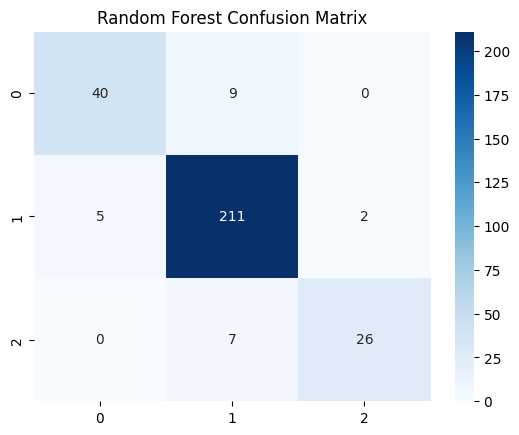

In [12]:
# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Gradient Boosting Parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 9, 'learning_rate': 0.05}
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           2       0.89      0.84      0.86        49
           3       0.94      0.97      0.95       218
           4       0.93      0.85      0.89        33

    accuracy                           0.93       300
   macro avg       0.92      0.88      0.90       300
weighted avg       0.93      0.93      0.93       300



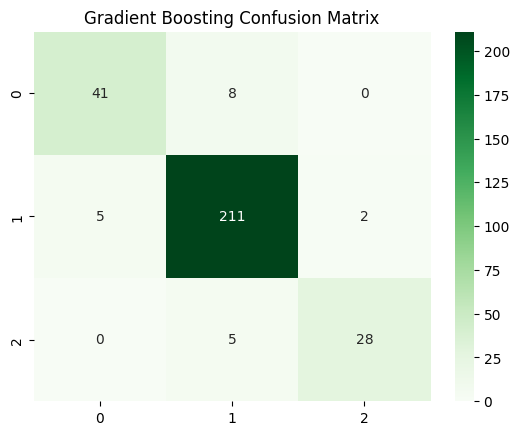

In [13]:
# Gradient Boosting Classifier with hyperparameter optimization
gb_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}

gb_model = GradientBoostingClassifier(random_state=seed)
gb_random_search = RandomizedSearchCV(gb_model, param_distributions=gb_params, n_iter=20, cv=3, random_state=seed, n_jobs=-1, verbose=1)
gb_random_search.fit(X_train_smote, y_train_smote)

# Best Gradient Boosting model
gb_best = gb_random_search.best_estimator_
print(f"Best Gradient Boosting Parameters: {gb_random_search.best_params_}")

# Predictions and Evaluation (Gradient Boosting)
gb_predictions = gb_best.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, gb_predictions))

# Confusion Matrix
gb_cm = confusion_matrix(y_test, gb_predictions)
sns.heatmap(gb_cm, annot=True, fmt='d', cmap='Greens')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

In [14]:
# Evaluate Model Accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
gb_accuracy = accuracy_score(y_test, gb_predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.4f}")

Random Forest Accuracy: 0.9233
Gradient Boosting Accuracy: 0.9333


In [15]:
# Logistic Regression, SVM, KNN, etc.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

# List of classifiers to train
classifiers = {
    "Logistic Regression": LogisticRegression(random_state=seed),
    "Support Vector Classifier": SVC(random_state=seed, probability=True),
    "Linear SVC": LinearSVC(random_state=seed),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Perceptron": Perceptron(random_state=seed),
    "Stochastic Gradient Descent": SGDClassifier(random_state=seed)
}


Training Logistic Regression...
Cross-validation average score for Logistic Regression: 0.8405
Logistic Regression Accuracy: 0.7333
              precision    recall  f1-score   support

           2       0.50      0.73      0.60        49
           3       0.82      0.83      0.83       218
           4       0.29      0.06      0.10        33

    accuracy                           0.73       300
   macro avg       0.54      0.54      0.51       300
weighted avg       0.71      0.73      0.71       300



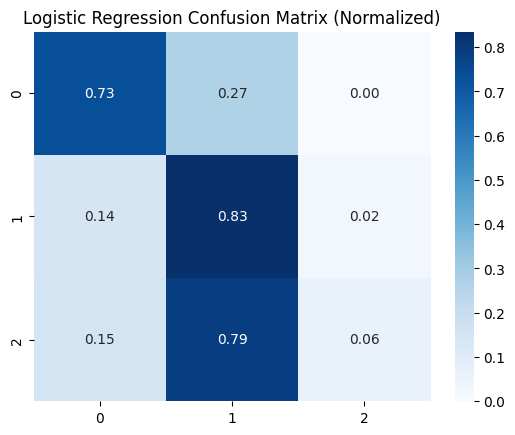


Training Support Vector Classifier...
Cross-validation average score for Support Vector Classifier: 0.8766
Support Vector Classifier Accuracy: 0.1633
              precision    recall  f1-score   support

           2       0.16      1.00      0.28        49
           3       0.00      0.00      0.00       218
           4       0.00      0.00      0.00        33

    accuracy                           0.16       300
   macro avg       0.05      0.33      0.09       300
weighted avg       0.03      0.16      0.05       300



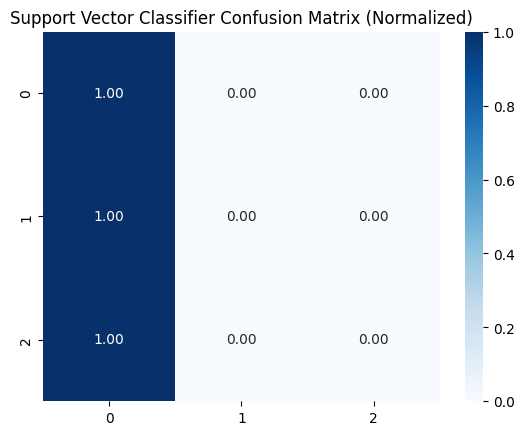


Training Linear SVC...
Cross-validation average score for Linear SVC: 0.8431
Linear SVC Accuracy: 0.5467
              precision    recall  f1-score   support

           2       0.25      0.71      0.37        49
           3       0.81      0.59      0.68       218
           4       0.00      0.00      0.00        33

    accuracy                           0.55       300
   macro avg       0.35      0.44      0.35       300
weighted avg       0.63      0.55      0.56       300



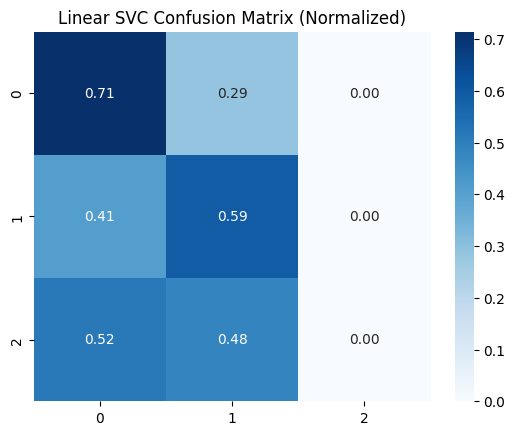


Training K-Nearest Neighbors...
Cross-validation average score for K-Nearest Neighbors: 0.9035
K-Nearest Neighbors Accuracy: 0.5133
              precision    recall  f1-score   support

           2       0.22      0.61      0.32        49
           3       0.76      0.57      0.65       218
           4       0.00      0.00      0.00        33

    accuracy                           0.51       300
   macro avg       0.33      0.39      0.32       300
weighted avg       0.59      0.51      0.52       300



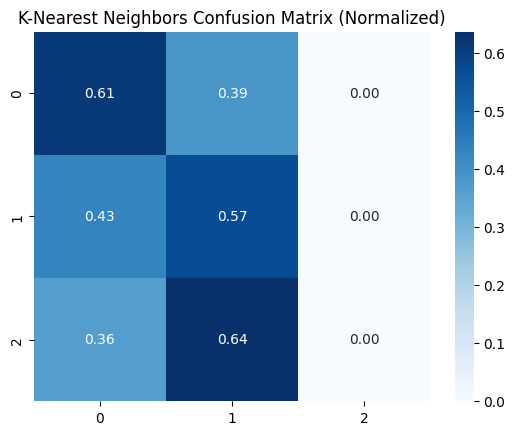


Training Naive Bayes...
Cross-validation average score for Naive Bayes: 0.6596
Naive Bayes Accuracy: 0.7267
              precision    recall  f1-score   support

           2       0.00      0.00      0.00        49
           3       0.73      1.00      0.84       218
           4       0.00      0.00      0.00        33

    accuracy                           0.73       300
   macro avg       0.24      0.33      0.28       300
weighted avg       0.53      0.73      0.61       300



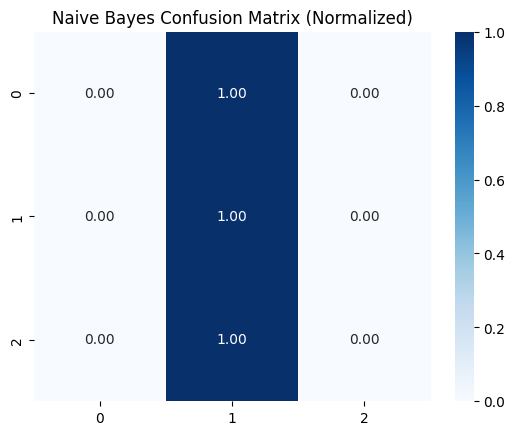


Training Decision Tree...
Cross-validation average score for Decision Tree: 0.9197
Decision Tree Accuracy: 0.2933
              precision    recall  f1-score   support

           2       0.16      0.53      0.24        49
           3       0.74      0.25      0.38       218
           4       0.11      0.21      0.15        33

    accuracy                           0.29       300
   macro avg       0.34      0.33      0.26       300
weighted avg       0.58      0.29      0.33       300



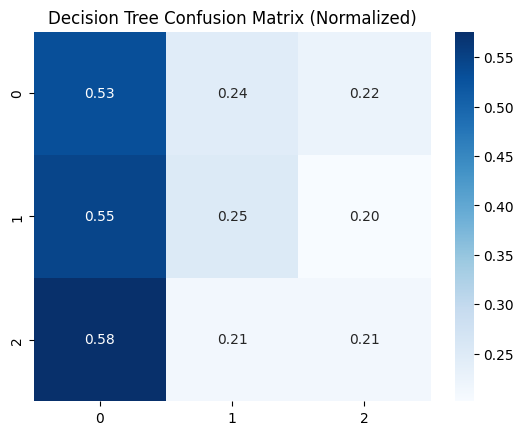


Training Perceptron...
Cross-validation average score for Perceptron: 0.8349
Perceptron Accuracy: 0.7433
              precision    recall  f1-score   support

           2       0.52      0.63      0.57        49
           3       0.82      0.87      0.84       218
           4       0.25      0.06      0.10        33

    accuracy                           0.74       300
   macro avg       0.53      0.52      0.50       300
weighted avg       0.71      0.74      0.72       300



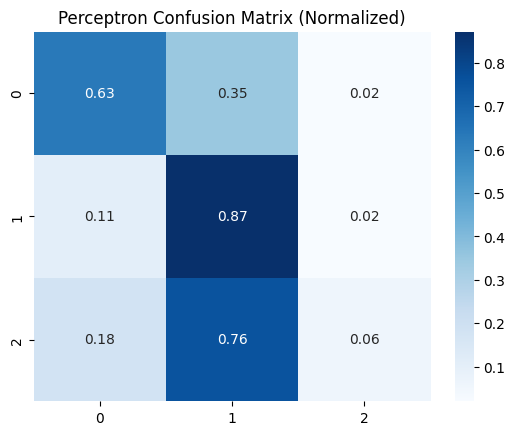


Training Stochastic Gradient Descent...
Cross-validation average score for Stochastic Gradient Descent: 0.8431
Stochastic Gradient Descent Accuracy: 0.6367
              precision    recall  f1-score   support

           2       0.35      0.86      0.49        49
           3       0.83      0.68      0.75       218
           4       0.00      0.00      0.00        33

    accuracy                           0.64       300
   macro avg       0.39      0.51      0.41       300
weighted avg       0.66      0.64      0.63       300



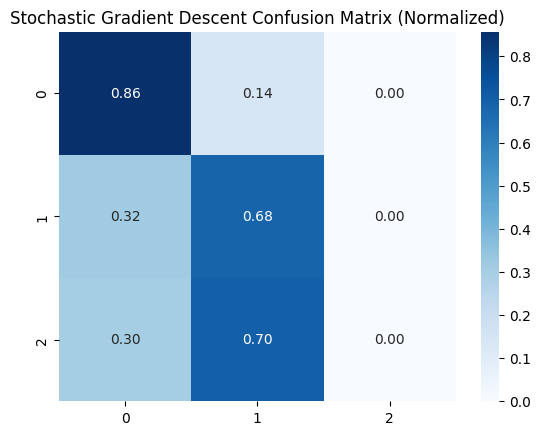

In [16]:
# Function to train, tune, and evaluate classifiers with cross-validation and feature importance
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    results = {}

    for name, clf in classifiers.items():
        print(f"\nTraining {name}...")

        # Hyperparameter tuning for KNN and Decision Tree using RandomizedSearchCV
        if name == "K-Nearest Neighbors":
            param_dist_knn = {
                'n_neighbors': np.arange(3, 25),
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
            random_search = RandomizedSearchCV(clf, param_distributions=param_dist_knn, n_iter=10, cv=5, random_state=seed)
            clf = random_search.fit(X_train, y_train).best_estimator_
        elif name == "Decision Tree":
            param_dist_tree = {
                'max_depth': np.arange(3, 15),
                'min_samples_split': np.arange(2, 10),
                'min_samples_leaf': np.arange(1, 10)
            }
            random_search = RandomizedSearchCV(clf, param_distributions=param_dist_tree, n_iter=10, cv=5, random_state=seed)
            clf = random_search.fit(X_train, y_train).best_estimator_

        # Cross-validation score (5-fold)
        cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
        print(f"Cross-validation average score for {name}: {np.mean(cv_scores):.4f}")

        # Fit the classifier on SMOTEd data
        clf.fit(X_train_smote, y_train_smote)

        # Predict on test data
        predictions = clf.predict(X_test_scaled)

        # Calculate accuracy and store results
        acc = accuracy_score(y_test, predictions)
        results[name] = acc
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, predictions))

        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions, normalize='true')
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
        plt.title(f"{name} Confusion Matrix (Normalized)")
        plt.show()


    return results

# Evaluate classifiers
results = evaluate_classifiers(classifiers, X_train_scaled, y_train_smote, X_test_scaled, y_test)


In [17]:
# Feature Selection using RFE
from sklearn.feature_selection import RFE
selector = RFE(estimator=rf_best, n_features_to_select=10, step=1)
selector.fit(X_train_smote, y_train_smote)
selected_features = final_data.columns[selector.support_]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['Age', 'DistanceFromHome', 'EmpEnvironmentSatisfaction',
       'EmpHourlyRate', 'EmpLastSalaryHikePercent',
       'ExperienceYearsAtThisCompany', 'ExperienceYearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EmpDepartment_Development'],
      dtype='object')


**Key Insights**

**Data Quality and Preparation:**

The notebook highlights the importance of checking for missing values and handling them before model training, ensuring data integrity.

**Categorical Encoding:**

One-hot encoding was effectively used to transform categorical variables into a numerical format, making them suitable for machine learning algorithms.

**Class Imbalance Handling:**

Implementing SMOTE (Synthetic Minority Over-sampling Technique) demonstrated an effective approach to addressing class imbalance, which can significantly improve model performance on underrepresented classes.

**Feature Scaling:**

Scaling the features using StandardScaler helps in normalizing the data, which is crucial for algorithms sensitive to feature scales.

**Model Selection and Performance:**

Both the Random Forest and Gradient Boosting models were implemented with hyperparameter tuning, showing a systematic approach to optimizing model performance.

The classification reports provided insights into precision, recall, and F1-scores, helping to assess the effectiveness of the models in predicting employee performance ratings.

**Confusion Matrix Visualization:**

Confusion matrices were utilized to visually evaluate model predictions, making it easier to identify misclassifications and understand model weaknesses.

**Diverse Classifier Evaluation:**

A variety of classifiers (Logistic Regression, SVC, KNN, etc.) were evaluated, allowing for a comprehensive comparison of model performances.

Cross-validation provided a reliable measure of performance, reducing the likelihood of overfitting.

**Feature Importance via RFE:**

The use of Recursive Feature Elimination (RFE) to identify important features indicates an understanding of how to simplify the model and enhance interpretability by focusing on significant predictors.

**Performance Metrics:**

Accuracy scores were calculated for each model, providing a straightforward metric for comparison, while classification reports detailed the strengths and weaknesses of each classifier.

**Visualizations for Interpretability:**

Confusion matrices and classification reports enhance interpretability and offer insights into model predictions, which is critical for making informed business decisions.